# Change Detection with DEMs

## Introduction

## Study Area

In [1]:
from pathlib import Path
import geopandas as gpd

# Create a GeoDataFrame from the GeoJson aoi file adjacent to this notebook
AOI_GEOJSON = Path(__name__).resolve().parent / "larger_aoi.geojson"
aoi: gpd.GeoDataFrame = gpd.read_file(AOI_GEOJSON)

In [2]:
aoi.head()

,geometry
0,"POLYGON ((-147.07426 61.10632, -147.07426 61.2..."


In [3]:
import leafmap


def initialize_default_interactive_map() -> leafmap.Map:
    # Initialize a default Map
    m = leafmap.Map()

    # Add helpful GUI elements to the map interface
    m.add_gui(name="layer_manager", position="topright", opened=False)

    return m

In [4]:
def create_interactive_aoi_map(aoi_geojson: Path) -> leafmap.Map:
    m = initialize_default_interactive_map()

    # Add data to the map. Each call to m.add_<something> places that data on the top of
    # the visual hierarchy. Therefore we will generally want to add basemaps first, rasters
    # second, and vectors last.

    # Add relevant basemaps
    m.add_basemap("Esri.WorldImagery", show=True)
    m.add_basemap("USGS.USImagery", show=False)

    # No raster data yet

    # Add vector data
    m.add_geojson(str(aoi_geojson), layer_name="Area of Interest", zoom_to_layer=True)

    return m


interactive_map = create_interactive_aoi_map(AOI_GEOJSON)
interactive_map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [11]:
del interactive_map

## Backgound Data

In [5]:
import pystac
import pystac_client
from pystac_client.item_search import ItemCollection

cop30_stac_info = {"collection": "cop-dem-glo-30", "asset_stac_key": "data"}

esa_stac_info = {"collection": "esa-worldcover", "asset_stac_key": "map"}

# https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02
land_stac_info = {"collection": "io-lulc-annual-v02", "asset_stac_key": "data"}


def search_planetary_computer_stac(
    collection: str,
    features: gpd.GeoDataFrame,
) -> ItemCollection:
    STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"

    dissolved_geom: gpd.GeoDataFrame = features.dissolve().iloc[0].geometry

    catalog = pystac_client.Client.open(STAC_URL)
    search = catalog.search(collections=[collection], intersects=dissolved_geom)
    return search.item_collection()


def get_asset_href(item: pystac.Item, asset_stac_key: str) -> str:
    return item.assets[asset_stac_key].href

In [14]:
import rioxarray

OUTPUT_DIR = Path(__name__).resolve().parent / "data"


def download_data(item: pystac.Item, asset_stac_key: str, output_dir: Path) -> None:
    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    url = get_asset_href(item, asset_stac_key)
    asset_id = item.id
    filename = f"{asset_id}.tif"
    filepath = output_dir / filename
    xds = rioxarray.open_rasterio(url).compute()
    xds.rio.to_raster(filepath)

In [7]:
cop30_items = search_planetary_computer_stac(
    collection=cop30_stac_info["collection"],
    features=aoi,
)
cop30_items

In [13]:
# download_data(cop30_items[0], cop30_stac_info["asset_stac_key"], OUTPUT_DIR)

In [8]:
esa_items = search_planetary_computer_stac(
    collection=esa_stac_info["collection"],
    features=aoi,
)
esa_items

In [23]:
# download_data(esa_items[0], esa_stac_info["asset_stac_key"], OUTPUT_DIR)

In [9]:
land_items = search_planetary_computer_stac(
    collection=land_stac_info["collection"],
    features=aoi,
)
land_items

In [16]:
download_data(land_items[0], land_stac_info["asset_stac_key"], OUTPUT_DIR)

In [17]:
cop30_xds = rioxarray.open_rasterio(OUTPUT_DIR / f"{cop30_items[0].id}.tif")

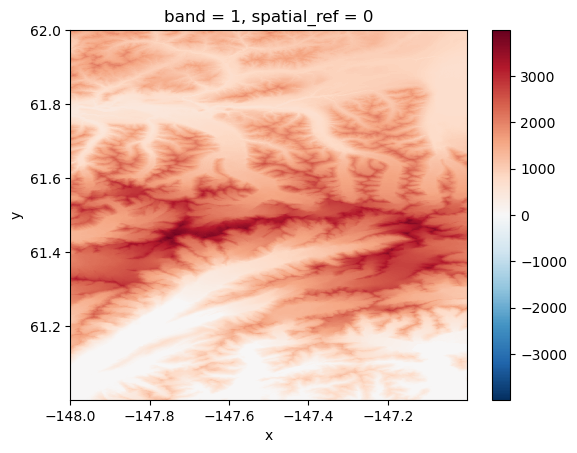

In [19]:
cop30_xds.plot()

In [20]:
land_xds = rioxarray.open_rasterio(OUTPUT_DIR / f"{land_items[0].id}.tif")

MemoryError: Unable to allocate 24.9 GiB for an array with shape (89439, 37415) and data type float64

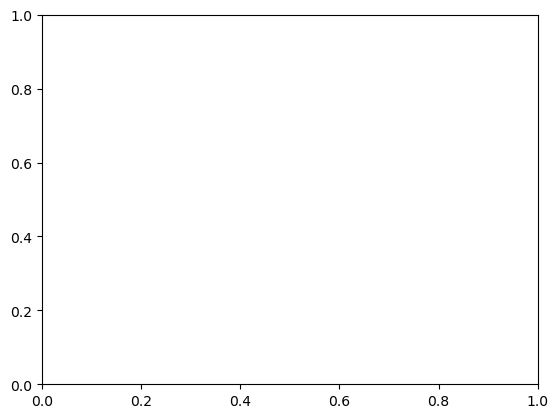

In [22]:
land_xds.plot()

In [ ]:
def create_interactive_background_data_map(
    aoi_geojson: Path, cogs: list[dict]
) -> leafmap.Map:
    m = initialize_default_interactive_map()

    # Add data to the map. Each call to m.add_<something> places that data on the top of
    # the visual hierarchy. Therefore we will generally want to add basemaps first, rasters
    # second, and vectors last.

    # Add relevant basemaps
    m.add_basemap("Esri.WorldImagery", show=True)
    m.add_basemap("USGS.USImagery", show=False)

    # Add Cloud Optimized GeoTiffs (COGs) from the Planetary Computer STAC search
    for cog in cogs:
        m.add_cog_layer(url=cog["href"], name=cog["name"])

    # Add vector data
    m.add_geojson(str(aoi_geojson), layer_name="Area of Interest", zoom_to_layer=True)

    return m


interactive_map = create_interactive_background_data_map(
    aoi_geojson=AOI_GEOJSON, cogs=[cop30_cog]
)
interactive_map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Finding Strip DEMs

## Prepare Strip DEMs for Analysis

## Visualizing Change with Differencing